## K-NN Classifier 

In [1]:
import numpy as np
import pandas as pd
import sklearn

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve

### Load the Wine Quality Dataset

In [2]:
column_names = ['fixed_acidity', 'volatile-acidity', 
                'citric-acid', 'residual-sugar', 
                'chlorides', 'free-sulphur-dioxide', 
                'total-sulpher-dioxide', 'density', 
                'pH', 'sulphates', 'alcohol', 'quality']
data = pd.read_csv("datasets/wine_quality/winequality-white.csv", sep=";")

data['quality'] = np.where(data['quality'] >= 5, 1, 0)

data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [3]:
target = data.loc[:, ['quality']]
target.head()

,quality
0,1
1,1
2,1
3,1
4,1


### Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002566AE8AF08>,
      dtype=object)

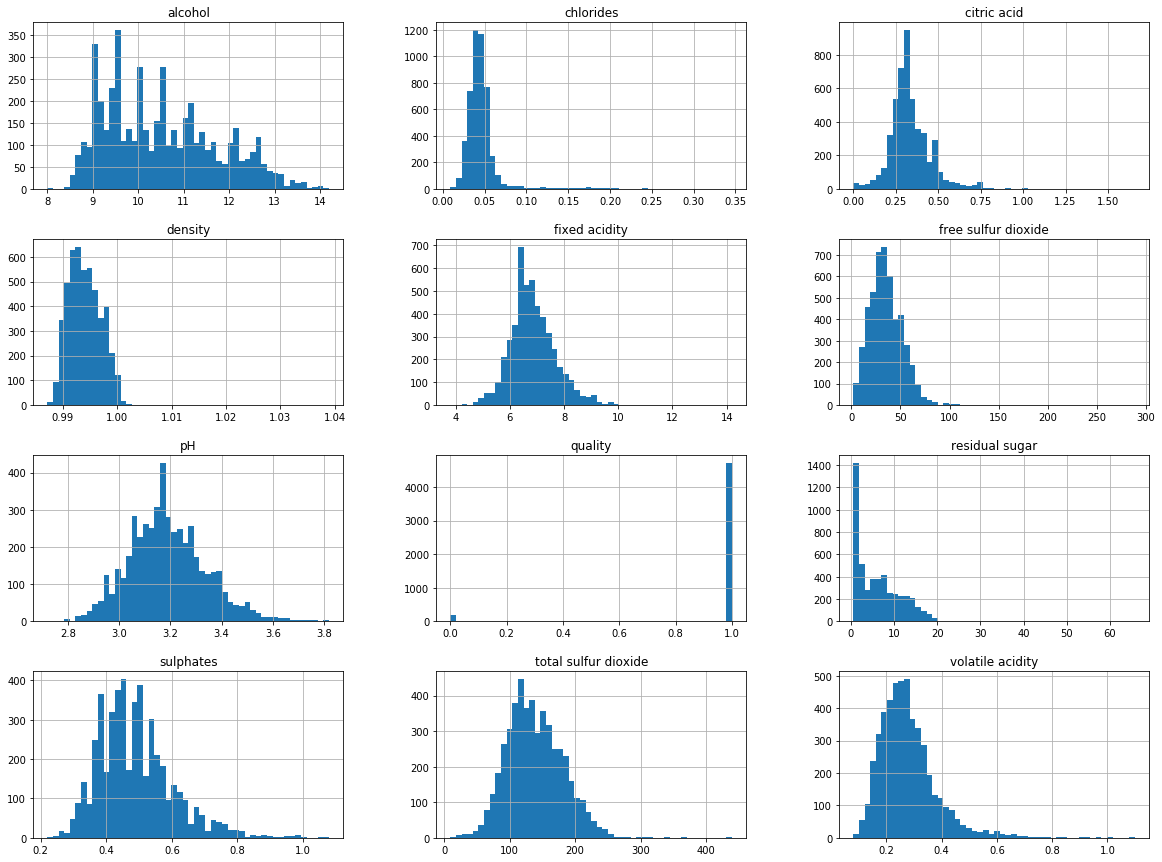

In [4]:
%matplotlib inline

data.hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002566AE8AF48>,
      dtype=object)

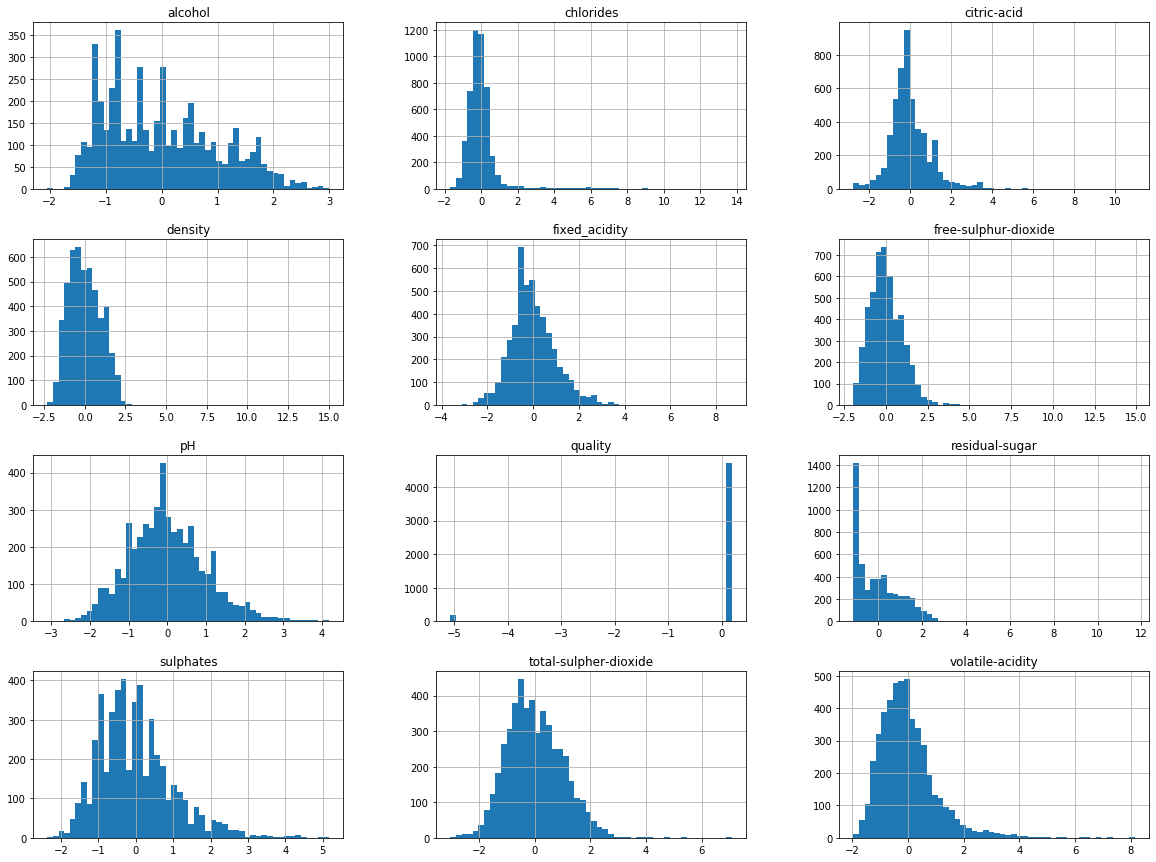

In [5]:
scaler = StandardScaler().fit(data)
features_std = scaler.transform(data)
df = pd.DataFrame(data=features_std[:],
                  index=list(range(0,len(features_std))),
                  columns=column_names)

df.hist(bins=50, figsize=(20, 15))

### Drop Redundent Features

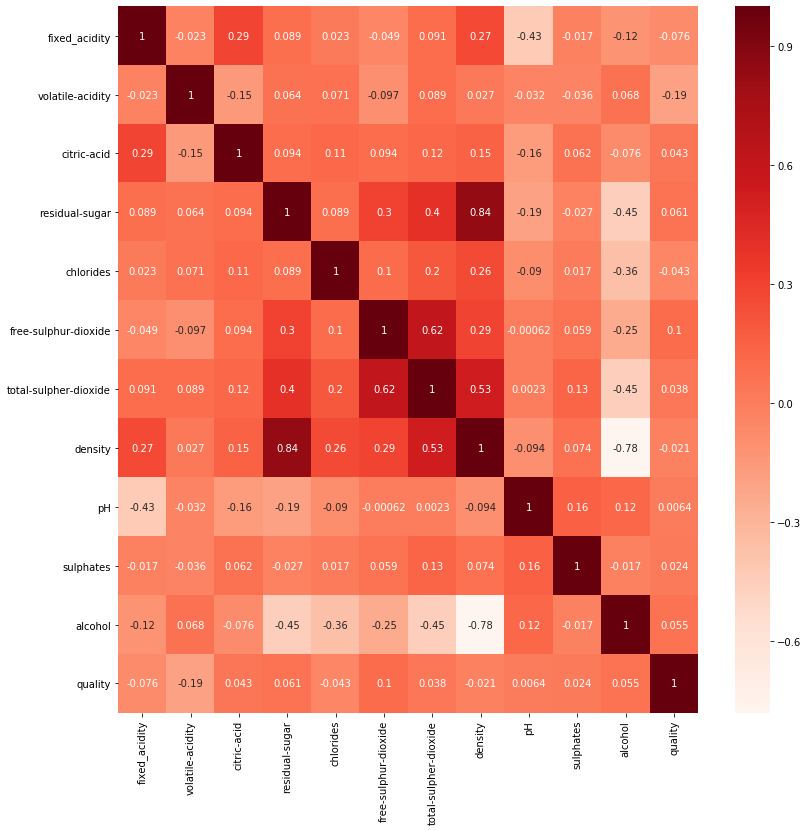

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(13,13))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
#Correlation with output variable
cor_target = abs(cor["quality"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.05]
relevant_features

fixed_acidity           0.076136
volatile-acidity        0.191062
residual-sugar          0.061003
free-sulphur-dioxide    0.100491
alcohol                 0.054559
quality                 1.000000
Name: quality, dtype: float64

In [8]:
df.drop(['citric-acid', 'chlorides', 'total-sulpher-dioxide', 'density', 'pH', 'sulphates'], axis=1, inplace=True)
df.head()

,fixed_acidity,volatile-acidity,residual-sugar,free-sulphur-dioxide,alcohol,quality
0,0.172097,-0.081770,2.821349,0.569932,-1.393152,0.197008
1,-0.657501,0.215896,-0.944765,-1.253019,-0.824276,0.197008
2,1.475751,0.017452,0.100282,-0.312141,-0.336667,0.197008
3,0.409125,-0.478657,0.415768,0.687541,-0.499203,0.197008
4,0.409125,-0.478657,0.415768,0.687541,-0.499203,0.197008


In [9]:
print(df[['fixed_acidity', 'volatile-acidity']].corr())
print(df[['residual-sugar', 'fixed_acidity']].corr())

df.drop('fixed_acidity', axis=1, inplace=True)
df.head()

                  fixed_acidity  volatile-acidity
fixed_acidity          1.000000         -0.022697
volatile-acidity      -0.022697          1.000000
                residual-sugar  fixed_acidity
residual-sugar        1.000000       0.089021
fixed_acidity         0.089021       1.000000


,volatile-acidity,residual-sugar,free-sulphur-dioxide,alcohol,quality
0,-0.081770,2.821349,0.569932,-1.393152,0.197008
1,0.215896,-0.944765,-1.253019,-0.824276,0.197008
2,0.017452,0.100282,-0.312141,-0.336667,0.197008
3,-0.478657,0.415768,0.687541,-0.499203,0.197008
4,-0.478657,0.415768,0.687541,-0.499203,0.197008


In [10]:
print(df[['residual-sugar', 'free-sulphur-dioxide']].corr())
print(df[['free-sulphur-dioxide', 'alcohol']].corr())

df.drop(['alcohol', 'quality'], axis=1, inplace=True)
df.head()

                      residual-sugar  free-sulphur-dioxide
residual-sugar              1.000000              0.299098
free-sulphur-dioxide        0.299098              1.000000
                      free-sulphur-dioxide   alcohol
free-sulphur-dioxide              1.000000 -0.250104
alcohol                          -0.250104  1.000000


,volatile-acidity,residual-sugar,free-sulphur-dioxide
0,-0.081770,2.821349,0.569932
1,0.215896,-0.944765,-1.253019
2,0.017452,0.100282,-0.312141
3,-0.478657,0.415768,0.687541
4,-0.478657,0.415768,0.687541


### Train-Test Split

In [11]:
mask = np.random.rand(len(df)) < 0.8
train_X = df[mask]
train_Y = target[mask]

print("Number of train examples: {}".format(len(train_X)))
print("Number of train labels: {}".format(len(train_Y)))

test_X = df[~mask]
test_Y = target[~mask]

print("Number of test examples: {}".format(len(test_X)))
print("Number of test labels: {}".format(len(test_Y)))

Number of train examples: 3909
Number of train labels: 3909
Number of test examples: 989
Number of test labels: 989


## K-NN Class

In [12]:
class kNN:
    def __init__(self):
        pass
    
    def euclidean_distance(self, vector1, vector2):
        diff = np.subtract(vector1, vector2)
        
        return np.sqrt(np.sum(np.power(diff, 2)))
    
    def manhatten_distance(self, vector1, vector2):
        return np.sum(np.absolute(vector1-vector2))
    
    def fit(self, X, Y, n_neighbors, weights='uniform', **kwargs):
        
        self.train_X = X
        self.Y = Y
        self.k = n_neighbors
        
    
    def predict(self, X, threshold=0.0, train=True):
        
        preds = []
        pred_idx = 0
        progress_count = 0
        total = len(X)
        probability_estimates = []
        print("No. of examples: {}".format(len(X)))
        
        # loop through each row
        for row in X:
            dist_arr = []
            class_arr = []
            if train:
                print("Training done {} %".format(round(progress_count/total*100)), end="\r")
            else:
                print("Testing done {} %".format(round(progress_count/total*100)), end="\r")
            progress_count += 1
            
            # loop through all the other training examples
            for ex in range(len(self.train_X)):
                # get the current row vector
                example = self.train_X[ex]
                # label for the current row
                label = self.Y[ex]
                if not np.array_equal(example, row):
                    # calculate the euclidean distance 
                    dist = self.manhatten_distance(example, row)
                    dist_arr.append(dist)
                    class_arr.append(label)
                    
            dist_arr = np.asarray(dist_arr)
            # get the sorted index from the distances
            dist_arr_sort_idx = np.argsort(dist_arr)
            
            # pick the top n closest neighbors
            dist_arr_sort_idx = dist_arr_sort_idx[:self.k]
            zeros = 0
            ones = 0
            
            # find the majority class
            for idx in dist_arr_sort_idx:
                if class_arr[idx] == 0:
                    zeros += 1
                else:
                    ones += 1
            
            # Using the threshold value to predict class
            zeros_frac = zeros / (zeros + ones)
            ones_frac = ones / (zeros + ones)
            probability_estimates.append(ones_frac)
            if zeros <= ones:
                if ones_frac >= threshold:
                    preds.append(1)
                else:
                    preds.append(0)
            else:
                if zeros_frac >= threshold:
                    preds.append(0)
                else:
                    preds.append(1)
                
            pred_idx += 1
        
        print("\nNumber of predictions: {}".format(len(preds)))
        return (np.asarray(preds), np.asarray(probability_estimates))
    
    
    def accuracy(self, preds, labels):
        #calculate accuracy
        error = 0
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                  error += 1
        
        matches = len(labels) - error
        
        print("Matching Predictions: {} out of {}".format(matches, len(labels)))
        
        accuracy = round(matches/len(labels)*100,2)
        loss = round(error/len(labels), 5)
        
        return [accuracy, loss] 

In [13]:
knn_classifier = kNN()


knn_classifier.fit(train_X.to_numpy(), train_Y.to_numpy(), 5)
predictions_train, prob_estimates_train = knn_classifier.predict(train_X.to_numpy())
train_accuracy, train_loss = knn_classifier.accuracy(predictions_train, train_Y.to_numpy())
print("Train Accuracy: {}%".format(train_accuracy))
print("Train Loss: {}".format(train_loss))

No. of examples: 3909
Training done 100 %
Number of predictions: 3909
Matching Predictions: 3755 out of 3909
Train Accuracy: 96.06%
Train Loss: 0.0394


In [15]:
knn_classifier = kNN()
knn_classifier.fit(train_X.to_numpy(), train_Y.to_numpy(), 5)

predictions_test, probability_estimates = knn_classifier.predict(test_X.to_numpy(), train=False)
test_accuracy, test_loss = knn_classifier.accuracy(predictions_test, test_Y.to_numpy())
# print("Threshold: {}".format(threshold))
print("Test Accuracy: {}%".format(test_accuracy))
print("Test Loss: {}".format(test_loss))

No. of examples: 989
Testing done 100 %
Number of predictions: 989
Matching Predictions: 952 out of 989
Test Accuracy: 96.26%
Test Loss: 0.03741


### Testing with SK-Learn

In [16]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_X, train_Y)
predictions = neigh.predict(test_X)

print("SK-Learn Test Accuracy: {}".format(accuracy_score(predictions, test_Y)))

SK-Learn Test Accuracy: 0.961577350859454


C:\Users\31892846\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


## Evaluating Model

In [35]:
print("\n Confusion Matrix Order\n")
print("[True Positives        False Negatives]\n\n[True Negatives        False Positives]\n")

print('Confusion Matrix Train Predictions\n')
conf_train = confusion_matrix(train_Y, predictions_train, labels=[1,0])
print(conf_train)

print('\nConfusion Matrix Test Predictions\n')
conf_test = confusion_matrix(test_Y, predictions_test, labels=[1,0])
print(conf_test)


 Confusion Matrix Order

[True Positives        False Negatives]

[True Negatives        False Positives]

Confusion Matrix Train Predictions

[[3737   24]
 [ 130   18]]

Confusion Matrix Test Predictions

[[949   5]
 [ 32   3]]


### Precision, Recall and F1 Score  (Train)

In [37]:
print("TRAIN DATA\n")

precision_tr = conf_train[0][0]/(conf_train[0][0] + conf_train[1][0])
recall_tr = conf_train[0][0]/(conf_train[0][0] + conf_train[0][1])
f1_tr = 2 * precision_tr * recall_tr / (precision_tr + recall_tr)
print("Scores\n")
print("Precision: %f" % precision_tr)
print("Recall = %f" % recall_tr)
print("F1 Score = %f" % f1_tr)

print("\nSK Learn Scores\n")
precision_tr_sk = precision_score(train_Y, predictions_train) 
recall_tr_sk = recall_score(train_Y, predictions_train)
f1_tr_sk = f1_score(train_Y, predictions_train)

print("Precision SK-Learn = %f" % precision_tr_sk)
print("Recall SK = %f" % recall_tr_sk)
print("F1 Score = %f" % f1_tr_sk)

TRAIN DATA

Scores

Precision: 0.966382
Recall = 0.993619
F1 Score = 0.979811

SK Learn Scores

Precision SK-Learn = 0.966382
Recall SK = 0.993619
F1 Score = 0.979811


### Precision, Recall and F1 Score (Test)

In [38]:
print("TEST DATA\n")
precision_te = precision_score(test_Y, predictions_test) 
print("Precision = %f" % precision_te)

recall_te = recall_score(test_Y, predictions_test) 
print("Recall = %f" % recall_te)


f1_te = f1_score(test_Y, predictions_test) 
print("F1 Score = %f" % f1_te)
print("=======================\n")

TEST DATA

Precision = 0.967380
Recall = 0.994759
F1 Score = 0.980879



In [39]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==1 and y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==0 and y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [47]:
tp, fp, tn, fn = perf_measure(test_Y.to_numpy(), predictions_test)
tpr_0 = tp/(tp+fn)
fpr_0 = fp/(tn + fp)
    
print("TPR: {}\nFPR: {}".format(tpr_0, fpr_0))

TPR: 0.9947589098532494
FPR: 0.9142857142857143


### Plotting ROC Curve

(989,)
TPR: [0.         0.48571429 0.8        0.91428571 0.97142857 1.        ]
FPR: [0.         0.87526205 0.98008386 0.99475891 1.         1.        ]
Threshold: [2.  1.  0.8 0.6 0.4 0.2]


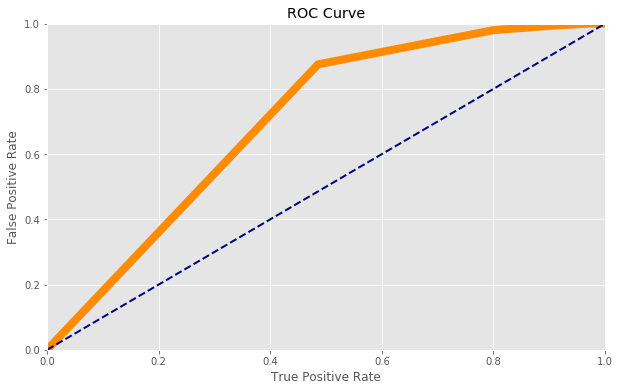

In [45]:
print(probability_estimates.shape)
tpr, fpr, thresholds = roc_curve(test_Y.to_numpy(), probability_estimates)
print("TPR: {}".format(tpr))
print("FPR: {}".format(fpr))
print("Threshold: {}".format(thresholds))

plt.style.use('ggplot')

fig = plt.figure(figsize=(10,6))
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(tpr, fpr, color='darkorange', linewidth=8, label=label)
    plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
    plt.axis([0,1,0,1])
    plt.title('ROC Curve')
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()